In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

tables = {
    "OE_Activity": "../data/database_backups_csv/OE/OE_Activity.csv",
    "OE_Locations": "../data/database_backups_csv/OE/OE_Locations.csv",
    "OE_Products": "../data/database_backups_csv/OE/OE_Products.csv",
}

column_names = {
    "OE_Activity": ["ActivityCode","UserID","WorkCode","AssignmentID","ProductID","Quantity","Timestamp","LocationID"],
    "OE_Locations": ["LocationID","Aisle","Bay","Level","Slot"],
    "OE_Products": ["ProductID","ProductCode","UnitOfMeasure","Weight","Cube","Length","Width","Height"],
}

dfs = {}
for name, fp in tables.items():
    dfs[name] = pd.read_csv(fp, header=None, names=column_names[name])

In [15]:
for t in ["OE_Activity", "OE_Locations", "OE_Products"]:
    print("=" * 80)
    print(f"Table: {t}")

    df = dfs[t]
    print(f"Dimensions: ({df.shape[0]} rows, {df.shape[1]} columns)\n")

    display(df.head(3))

    # Columns and data types + quick summary stats
    schema_df = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_missing": df.isna().sum(),
        "n_unique": df.nunique(dropna=True),
    })

    # Numeric summaries
    num_df = df.select_dtypes(include="number")
    schema_df["min"] = num_df.min()
    schema_df["max"] = num_df.max()
    schema_df["mean"] = num_df.mean()

    display(schema_df)
    print("\n")

Table: OE_Activity
Dimensions: (96132 rows, 8 columns)



,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID
0,PickPut,419,20,7954566,4289.0,1.0,2025-11-10 11:37:14.160,826367.0
1,AssignmentOpen,64,10,7954429,NaN,NaN,2025-11-10 11:38:34.043,NaN
2,PickPut,419,20,7954541,6592.0,1.0,2025-11-10 11:39:42.330,14524.0


,dtype,n_missing,n_unique,min,max,mean
ActivityCode,object,0,2,NaN,NaN,NaN
UserID,int64,0,40,64.0,504.0,4.050262e+02
WorkCode,int64,0,3,10.0,30.0,2.642034e+01
AssignmentID,int64,0,42241,7717782.0,8042473.0,7.924902e+06
ProductID,float64,894,7691,1.0,57791.0,2.477778e+04
Quantity,float64,894,144,1.0,1143.0,8.453474e+00
Timestamp,object,0,95804,NaN,NaN,NaN
LocationID,float64,894,7669,1.0,8104198.0,8.932247e+05




Table: OE_Locations
Dimensions: (33519 rows, 5 columns)



,LocationID,Aisle,Bay,Level,Slot
0,1,10,24.0,1.0,1.0
1,2,40,5.0,4.0,4.0
2,3,40,9.0,1.0,2.0


,dtype,n_missing,n_unique,min,max,mean
LocationID,int64,0,33519,1.0,8034868.0,795274.768400
Aisle,object,0,52,NaN,NaN,NaN
Bay,float64,1,86,1.0,99.0,23.107107
Level,float64,1,12,1.0,50.0,3.687153
Slot,float64,1,35,1.0,35.0,3.019243




Table: OE_Products
Dimensions: (57671 rows, 8 columns)



,ProductID,ProductCode,UnitOfMeasure,Weight,Cube,Length,Width,Height
0,1,07062B2324X,CA,35.0000,0.938,NaN,NaN,NaN
1,2,0204800418,BX,2.7338,0.263,NaN,NaN,NaN
2,3,07062B1322Q,EA,0.6500,0.027,NaN,NaN,NaN


,dtype,n_missing,n_unique,min,max,mean
ProductID,int64,0,57671,1.0,57671.000,28836.000000
ProductCode,object,0,41981,NaN,NaN,NaN
UnitOfMeasure,object,0,55,NaN,NaN,NaN
Weight,float64,0,5572,0.0,7584.000,4.834848
Cube,float64,0,4009,0.0,421.296,0.623222
Length,float64,57671,0,NaN,NaN,NaN
Width,float64,57671,0,NaN,NaN,NaN
Height,float64,57671,0,NaN,NaN,NaN


In [16]:
OE_Activity = dfs["OE_Activity"]

# OE_Locations's Bay, level, slot all to int
OE_Locations = dfs["OE_Locations"]# Convert Bay, Level, Slot to integers (nullable Int64)
OE_Locations["Bay"]   = pd.to_numeric(OE_Locations["Bay"], errors="coerce").astype("Int64")
OE_Locations["Level"] = pd.to_numeric(OE_Locations["Level"], errors="coerce").astype("Int64")
OE_Locations["Slot"]  = pd.to_numeric(OE_Locations["Slot"], errors="coerce").astype("Int64")

OE_Products = dfs["OE_Products"][["ProductID", "ProductCode", "UnitOfMeasure", "Weight", "Cube"]]

## EDA on Single User in a day

In [17]:
# extract a table for UserID 419 where Timestamp is 2025-11-10, and sorted by Timestamp
user419_nov10 = dfs["OE_Activity"][
    (dfs["OE_Activity"]["UserID"] == 419) &
    (pd.to_datetime(dfs["OE_Activity"]["Timestamp"], errors="coerce").dt.date == pd.to_datetime("2025-11-10").date())].copy()
user419_nov10["Timestamp"] = pd.to_datetime(user419_nov10["Timestamp"], errors="coerce")
user419_nov10 = user419_nov10.sort_values(by="Timestamp").reset_index(drop=True)    
display(user419_nov10.head())
# Display rows with time delta larger than 1800 seconds and their previous row
user419_nov10["Time_Delta_sec"] = user419_nov10["Timestamp"].diff().dt.total_seconds()
large_gaps = user419_nov10[user419_nov10["Time_Delta_sec"] > 1800]
for idx in large_gaps.index:
    if idx > 0:
        display(user419_nov10.loc[idx-1:idx]) 

,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID
0,PickPut,419,20,7954566,4289.0,1.0,2025-11-10 11:37:14.160,826367.0
1,PickPut,419,20,7954541,6592.0,1.0,2025-11-10 11:39:42.330,14524.0
2,PickPut,419,20,7954542,6592.0,1.0,2025-11-10 11:39:42.883,14524.0
3,PickPut,419,20,7954543,6592.0,1.0,2025-11-10 11:39:43.483,14524.0
4,PickPut,419,20,7954544,6592.0,1.0,2025-11-10 11:39:43.863,14524.0


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Time_Delta_sec
153,PickPut,419,10,7955372,17263.0,1.0,2025-11-10 14:17:10.737,29825.0,38.987
154,PickPut,419,10,7955372,873.0,2.0,2025-11-10 14:50:22.673,7081.0,1991.936


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Time_Delta_sec
192,PickPut,419,10,7957410,996.0,1.0,2025-11-10 16:13:50.963,32139.0,37.770
193,PickPut,419,10,7957410,43513.0,25.0,2025-11-10 17:08:49.397,32139.0,3298.434


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Time_Delta_sec
236,PickPut,419,10,7957408,47663.0,2.0,2025-11-10 18:15:18.070,70607.0,0.160
237,PickPut,419,20,7957419,30425.0,1.0,2025-11-10 18:47:54.727,16694.0,1956.657


In [18]:
# Check n rows in user419_nov10
print(f"Number of rows for UserID 419 on 2025-11-10: {user419_nov10.shape[0]}")
# Check unique number of AssignmentID
print(f"Number of unique AssignmentID for UserID 419 on 2025-11-10: {user419_nov10['AssignmentID'].nunique()}")
# Check how many AssignmentID counts == 1
assignment_counts = user419_nov10['AssignmentID'].value_counts()
single_assignment_count = (assignment_counts == 1).sum()
print(f"Number of AssignmentID with only 1 record for UserID 419 on 2025-11-10: {single_assignment_count}")
# Display the rows with AssignmentID that appear the most
most_frequent_assignment = assignment_counts.idxmax()
display(user419_nov10[user419_nov10["AssignmentID"] == most_frequent_assignment].head())

Number of rows for UserID 419 on 2025-11-10: 549
Number of unique AssignmentID for UserID 419 on 2025-11-10: 472
Number of AssignmentID with only 1 record for UserID 419 on 2025-11-10: 464


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Time_Delta_sec
183,AssignmentOpen,419,10,7957410,NaN,NaN,2025-11-10 15:42:35.720,NaN,76.773
184,PickPut,419,10,7957410,17057.0,3.0,2025-11-10 15:44:27.957,196405.0,112.237
185,PickPut,419,10,7957410,1055.0,2.0,2025-11-10 16:05:30.803,136177.0,1262.846
186,PickPut,419,10,7957410,54061.0,3.0,2025-11-10 16:06:47.810,42637.0,77.007
187,PickPut,419,10,7957410,3236.0,3.0,2025-11-10 16:09:50.767,6780.0,182.957


In [19]:
user419_nov10["Count"] = (user419_nov10["ProductID"] != user419_nov10["ProductID"].shift()).cumsum()

user419_nov10_grouped = (
    user419_nov10
    .groupby("Count", dropna=False)
    .agg(
        ActivityCode=("ActivityCode", "first"),
        WorkCode=("WorkCode", "first"),
        ProductID=("ProductID", "first"),
        Quantity=("Quantity", "sum"),
        Timestamp_Start=("Timestamp", "first"),
        Timestamp_End=("Timestamp", "last"),
        LocationID=("LocationID", "first"),
    )
    .reset_index(drop=True)
)

# Duration within each group
user419_nov10_grouped["Duration_sec"] = (
    user419_nov10_grouped["Timestamp_End"] - user419_nov10_grouped["Timestamp_Start"]
).dt.total_seconds()

# Time delta from previous group's end to current group's start
user419_nov10_grouped["Time_Delta_sec"] = (
    user419_nov10_grouped["Timestamp_Start"] - user419_nov10_grouped["Timestamp_End"].shift(1)
).dt.total_seconds()

display(user419_nov10_grouped.head())

,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec
0,PickPut,20,4289.0,1.0,2025-11-10 11:37:14.160,2025-11-10 11:37:14.160,826367.0,0.000,NaN
1,PickPut,20,6592.0,6.0,2025-11-10 11:39:42.330,2025-11-10 11:39:44.823,14524.0,2.493,148.170
2,PickPut,20,57606.0,1.0,2025-11-10 11:40:39.313,2025-11-10 11:40:39.313,256789.0,0.000,54.490
3,PickPut,20,24283.0,2.0,2025-11-10 11:42:02.237,2025-11-10 11:42:02.610,25287.0,0.373,82.924
4,PickPut,20,8773.0,1.0,2025-11-10 11:42:37.260,2025-11-10 11:42:37.260,25169.0,0.000,34.650


In [20]:
# Join user419_nov10_grouped with OE_Products to get ProductCode and other product details
user419_nov10_detailed = user419_nov10_grouped.merge(
    OE_Products,
    on="ProductID",
    how="left"
)
# Join user419_nov10_grouped with OE_Locations to get location details
user419_nov10_detailed = user419_nov10_detailed.merge(
    OE_Locations,
    on="LocationID",
    how="left"
)
display(user419_nov10_detailed.head())

,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,UnitOfMeasure,Weight,Cube,Aisle,Bay,Level,Slot
0,PickPut,20,4289.0,1.0,2025-11-10 11:37:14.160,2025-11-10 11:37:14.160,826367.0,0.000,NaN,5570002914,CA,6.72,0.667,12,10,1,1
1,PickPut,20,6592.0,6.0,2025-11-10 11:39:42.330,2025-11-10 11:39:44.823,14524.0,2.493,148.170,6996VP501MG,CS,4.80,0.734,14,28,1,2
2,PickPut,20,57606.0,1.0,2025-11-10 11:40:39.313,2025-11-10 11:40:39.313,256789.0,0.000,54.490,0657N21BCC10,CA,0.00,0.000,16,40,2,1
3,PickPut,20,24283.0,2.0,2025-11-10 11:42:02.237,2025-11-10 11:42:02.610,25287.0,0.373,82.924,430400704B,CA,15.00,1.440,18,19,1,1
4,PickPut,20,8773.0,1.0,2025-11-10 11:42:37.260,2025-11-10 11:42:37.260,25169.0,0.000,34.650,072300MZ5304,CS,1.80,0.636,18,22,1,1


In [21]:
# Load and process distance matrix
import numpy as np

path = "../data/distance_matrices/distance_matrix_OE.csv"
Distance = pd.read_csv(path, index_col=0)

for c in Distance.columns:
    Distance[c] = pd.to_numeric(Distance[c], errors="coerce")

display(Distance.head())

,08|03|||,08|05|||,08|07|||,08|09|||,10|04|||,10|06|||,10|08|||,10|10|||,10|12|||,10|14|||,...,|Start L3,|Start L4,|Start L5,|Start L6,|Start R2,|Start R3,|Start R4,|Start R5,|Start R6,|Start SB
08|03|||,0,414,389,364,304,287,271,255,240,223,...,1094,1068,897,953,1080,1045,1089,913,969,994
08|05|||,25,0,414,389,329,312,296,280,265,248,...,1119,1093,922,978,1104,1070,1113,938,994,1018
08|07|||,50,25,0,414,354,337,321,305,290,273,...,1144,1118,947,1003,1129,1095,1138,963,1019,1043
08|09|||,75,50,25,0,379,362,346,330,315,298,...,1169,1143,972,1028,1154,1119,1163,988,1044,1068
10|04|||,484,459,434,410,0,19,35,51,67,81,...,1120,1074,958,838,929,1133,1087,971,854,767


In [22]:
df = user419_nov10_detailed.copy()
# Make sure df is sorted by Timestamp_Start
df = df.sort_values(by="Timestamp_Start").reset_index(drop=True)

df["Aisle2"] = df["Aisle"].astype(str).str.zfill(2)
df["Bay2"]   = df["Bay"].astype(str).str.zfill(2)

# Build matrix key to match Distance index/columns: "08|03|||"
df["LocKey"] = df["Aisle2"] + "|" + df["Bay2"] + "|||"

# Previous location key (row i-1)
df["PrevLocKey"] = df["LocKey"].shift(1)

In [23]:
# Reshape Distance matrix to long format for easier merging
dist_long = (
    Distance.stack(dropna=False)
    .rename("distance")
    .reset_index()
    .rename(columns={"level_0": "FromLoc", "level_1": "ToLoc"})
)
# Merge to get distances
df = df.merge(
    dist_long,
    left_on=["LocKey", "PrevLocKey"],
    right_on=["FromLoc", "ToLoc"],
    how="left"
).rename(columns={"distance": "Dist_prev_to_curr"}).drop(columns=["FromLoc", "ToLoc"])
df = df.merge(
    dist_long,
    left_on=["PrevLocKey", "LocKey"],
    right_on=["FromLoc", "ToLoc"],
    how="left"
).rename(columns={"distance": "Dist_curr_to_prev"}).drop(columns=["FromLoc", "ToLoc"])

display(df.head())

/var/folders/hs/r4ck14j54v17d80mrc1wt5kw0000gn/T/ipykernel_14009/4188640830.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  Distance.stack(dropna=False)


,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,...,Aisle,Bay,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev
0,PickPut,20,4289.0,1.0,2025-11-10 11:37:14.160,2025-11-10 11:37:14.160,826367.0,0.000,NaN,5570002914,...,12,10,1,1,12,10,12|10|||,None,NaN,NaN
1,PickPut,20,6592.0,6.0,2025-11-10 11:39:42.330,2025-11-10 11:39:44.823,14524.0,2.493,148.170,6996VP501MG,...,14,28,1,2,14,28,14|28|||,12|10|||,652.0,220.0
2,PickPut,20,57606.0,1.0,2025-11-10 11:40:39.313,2025-11-10 11:40:39.313,256789.0,0.000,54.490,0657N21BCC10,...,16,40,2,1,16,40,16|40|||,14|28|||,357.0,532.0
3,PickPut,20,24283.0,2.0,2025-11-10 11:42:02.237,2025-11-10 11:42:02.610,25287.0,0.373,82.924,430400704B,...,18,19,1,1,18,19,18|19|||,16|40|||,249.0,642.0
4,PickPut,20,8773.0,1.0,2025-11-10 11:42:37.260,2025-11-10 11:42:37.260,25169.0,0.000,34.650,072300MZ5304,...,18,22,1,1,18,22,18|22|||,18|19|||,369.0,25.0


In [24]:
# Create new column showing avg of both distances
df["Dist_Avg"] = (df["Dist_prev_to_curr"] + df["Dist_curr_to_prev"]) / 2
# Compute a Speed metric: Distance Avg divided by Time Delta (in seconds)
df["Speed"] = df["Dist_Avg"] / df["Time_Delta_sec"]

display(df.head()) 

,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,...,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev,Dist_Avg,Speed
0,PickPut,20,4289.0,1.0,2025-11-10 11:37:14.160,2025-11-10 11:37:14.160,826367.0,0.000,NaN,5570002914,...,1,1,12,10,12|10|||,None,NaN,NaN,NaN,NaN
1,PickPut,20,6592.0,6.0,2025-11-10 11:39:42.330,2025-11-10 11:39:44.823,14524.0,2.493,148.170,6996VP501MG,...,1,2,14,28,14|28|||,12|10|||,652.0,220.0,436.0,2.942566
2,PickPut,20,57606.0,1.0,2025-11-10 11:40:39.313,2025-11-10 11:40:39.313,256789.0,0.000,54.490,0657N21BCC10,...,2,1,16,40,16|40|||,14|28|||,357.0,532.0,444.5,8.157460
3,PickPut,20,24283.0,2.0,2025-11-10 11:42:02.237,2025-11-10 11:42:02.610,25287.0,0.373,82.924,430400704B,...,1,1,18,19,18|19|||,16|40|||,249.0,642.0,445.5,5.372389
4,PickPut,20,8773.0,1.0,2025-11-10 11:42:37.260,2025-11-10 11:42:37.260,25169.0,0.000,34.650,072300MZ5304,...,1,1,18,22,18|22|||,18|19|||,369.0,25.0,197.0,5.685426


In [25]:
print(f"Total pick tasks(grouped) for user 419 on 2025-11-10: {df.shape[0]}")
print(f"Total quantity picked for user 419 on 2025-11-10: {df['Quantity'].sum()}")

# Count number of ActivityCode that is "AssignmentOpen"
assignment_open_count = (df["ActivityCode"] == "AssignmentOpen").sum()
print(f"Number of 'AssignmentOpen' ActivityCode: {assignment_open_count}")

# Average Time_Delta_sec between pick tasks
avg_time_delta = df["Time_Delta_sec"].mean()
print(f"Average Time Delta between pick tasks: {avg_time_delta:.2f} seconds")

# Average Dist_prev_to_curr
avg_dist = df["Dist_prev_to_curr"].mean()
print(f"Average Distance travelled: {avg_dist:.2f} units")

Total pick tasks(grouped) for user 419 on 2025-11-10: 277
Total quantity picked for user 419 on 2025-11-10: 771.0
Number of 'AssignmentOpen' ActivityCode: 12
Average Time Delta between pick tasks: 152.75 seconds
Average Distance travelled: 400.12 units


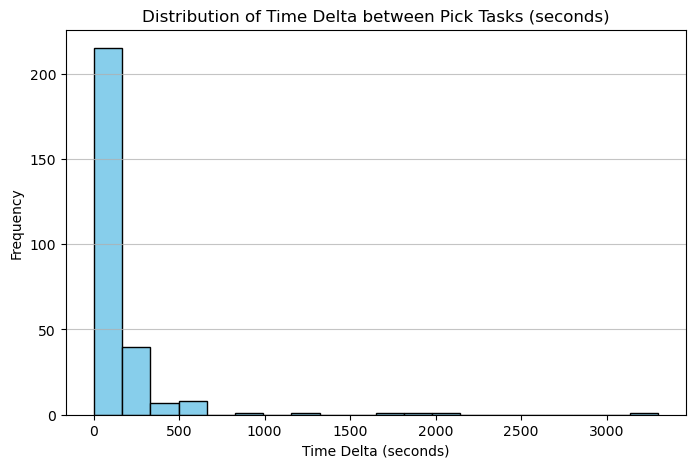

In [130]:
# Plot distribution of Time_Delta_sec
plt.figure(figsize=(8, 5))
plt.hist(df["Time_Delta_sec"].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Time Delta between Pick Tasks (seconds)")
plt.xlabel("Time Delta (seconds)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [131]:
# Percentage of Time_Delta_sec less than 120s, > 300s
pct_under_120s = (df["Time_Delta_sec"] < 120).mean() * 100
print(f"Percentage of Time Delta less than 120 seconds: {pct_under_120s:.2f}%")
pct_over_300s = (df["Time_Delta_sec"] > 300).mean() * 100
print(f"Percentage of Time Delta greater than 300 seconds: {pct_over_300s:.2f}%")
pct_over_600s = (df["Time_Delta_sec"] > 600).mean() * 100
print(f"Percentage of Time Delta greater than 600 seconds: {pct_over_600s:.2f}%")

Percentage of Time Delta less than 120 seconds: 69.68%
Percentage of Time Delta greater than 300 seconds: 9.03%
Percentage of Time Delta greater than 600 seconds: 2.17%


In [132]:
# Check the row and row above for Time_Delta_sec > 1800
long_gaps = df[df["Time_Delta_sec"] > 1800]
for idx in long_gaps.index:
    if idx > 0:
        display(df.loc[[idx - 1, idx]])

,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,...,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev,Dist_Avg,Speed
83,PickPut,10,17263.0,1.0,2025-11-10 14:17:10.737,2025-11-10 14:17:10.737,29825.0,0.0,38.987,3280510113,...,1,1,35,07,35|07|||,34|13|||,220.0,155.0,187.5,4.809295
84,PickPut,10,873.0,2.0,2025-11-10 14:50:22.673,2025-11-10 14:50:22.673,7081.0,0.0,1991.936,358340000000,...,7,4,36,33,36|33|||,35|07|||,341.0,432.0,386.5,0.194032


,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,...,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev,Dist_Avg,Speed
110,PickPut,10,996.0,1.0,2025-11-10 16:13:50.963,2025-11-10 16:13:50.963,32139.0,0.0,37.770,678305031750,...,1,2,12,31,12|31|||,12|18|||,660.0,134.0,397.0,10.510988
111,PickPut,10,43513.0,25.0,2025-11-10 17:08:49.397,2025-11-10 17:08:49.397,32139.0,0.0,3298.434,678305031750,...,1,2,12,31,12|31|||,12|31|||,0.0,0.0,0.0,0.000000


,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,Duration_sec,Time_Delta_sec,ProductCode,...,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev,Dist_Avg,Speed
149,PickPut,10,47663.0,4.0,2025-11-10 18:15:17.910,2025-11-10 18:15:18.070,70607.0,0.16,230.917,0723382544,...,2,3,41,06,41|06|||,85|05|||,197.0,196.0,196.5,0.850955
150,PickPut,20,30425.0,2.0,2025-11-10 18:47:54.727,2025-11-10 18:47:55.197,16694.0,0.47,1956.657,3642043008,...,1,2,15,20,15|20|||,41|06|||,861.0,682.0,771.5,0.394295


In [133]:
# Check all Product_ID with Product_Code = 678305031750
product_ids = OE_Products[OE_Products["ProductCode"] == "678305031750"]["ProductID"].unique()
print(f"Product IDs with Product Code 678305031750: {product_ids}")

Product IDs with Product Code 678305031750: [  719   996  1103 43513]


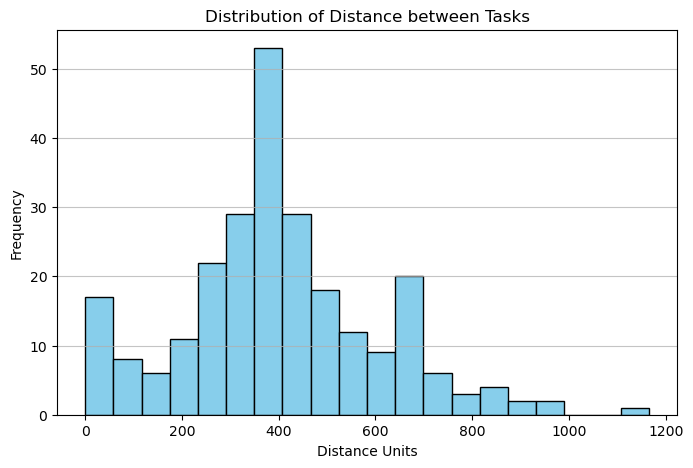

In [134]:
# Plot distribution of Dist_prev_to_curr
plt.figure(figsize=(8, 5))
plt.hist(df["Dist_prev_to_curr"].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Distance between Tasks")
plt.xlabel("Distance Units")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()